# MrBeast Words Analysis

We'll start by importing the necessary libraries and defining helper classes and functions.

In [1]:
import sys
import os
import re
import json
from collections import defaultdict
from pprint import pprint
from statistics import mean, stdev
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
# First time only
# import nltk
# nltk.download('all')

PUNCTUATION_RE = re.compile('[-;,.\'\"\\!\\?,]')
DICTIONARY_FILE = 'words_dictionary.json'


## Captions Parsing and Indexing

In this section, we define the `WordRef` class and the `Parser` class to handle the parsing and indexing of caption data.

In [2]:
class WordRef:
    def __init__(self):
        self.word = None
        self.start = None
        self.duration = None
        self.text = None
        self.videoId = None
        self.title = None
        self.publishedAt = None
        self.prev_ref = None
        self.next_ref = None
        self.link = None
        self.last_in_sentence = False

    def __str__(self):
        return self.__repr__()
    def __repr__(self):
        return str({
            'word': self.word,
            'start': self.start,
            'duration': self.duration,
            'text' : self.text,
            'videoId' : self.videoId,
            'title' : self.title,
            'publishedAt' : self.publishedAt,
            'link': self.link,
            'last_in_sentence': self.last_in_sentence,
            })

class Parser:
    def parse(self, directory, cut_off_date=None):
        self.word_index = defaultdict(list)
        self.first_word_in_video = {}
        self.video_lengths = []
        self.video_counter = 0
        self.video_stats = {}
        self.total_caption_time_secs = 0.0
        with open(DICTIONARY_FILE) as f:
            self.words_dictionary = json.load(f)
        
        filenames = os.listdir(directory)
        for filename in filenames:
            filepath = os.path.join(directory, filename)
            with open(filepath) as f:
                obj = json.load(f)
                title = obj['title'].replace('&#39;',"'")
                publishedAt = obj['publishedAt']
                if cut_off_date and publishedAt < cut_off_date:
                    continue
                self.video_counter += 1

                videoId = obj['id']
                captions = obj['captions']
                self.video_stats[videoId] = obj['stats']
                self.buildIndex(videoId, title.encode('utf-8'), publishedAt, captions)
                
                if len(captions) > 10:
                    length = captions[-1]['start'] + captions[-1]['duration']
                    self.video_lengths.append((length,videoId))
            
        self.video_lengths.sort()

        
    def buildIndex(self, videoId, title, publishedAt, captions):
        prev_ref = None
        for caption in captions:
            words = caption['text'].split()
            for word in words:
                last_in_sentence = False
                if re.search(PUNCTUATION_RE, word):
                    last_in_sentence = True
                    
                word = re.sub("[\\W]",'',word.lower())
                if not word:
                    continue
                ref = WordRef()
                ref.word = word
                ref.start = caption['start']
                ref.duration = caption['duration']
                ref.text = caption['text']
                ref.videoId = videoId
                ref.title = title
                ref.publishedAt = publishedAt
                ref.prev_ref = prev_ref
                ref.link = 'https://www.youtube.com/watch?v=%s&t=%ds' % (videoId, caption['start'])
                ref.last_in_sentence = last_in_sentence
                ref.is_in_dictionary = word in self.words_dictionary

                if prev_ref:
                    prev_ref.next_ref = ref
                else:  # first ref for this video
                    self.first_word_in_video[videoId] = ref
                self.word_index[word].append(ref)
                prev_ref = ref

        # Extract and store n-grams (up to trigrams)
        for caption in captions:
            words = caption['text'].split()
            for n in range(2, 4):  # for bigrams and trigrams
                for ngram in ngrams(words, n):
                    ngram_word = ' '.join(ngram).lower()
                    ref = WordRef()
                    ref.word = ngram_word
                    ref.start = caption['start']
                    ref.duration = caption['duration']
                    ref.text = caption['text']
                    ref.videoId = videoId
                    ref.title = title
                    ref.publishedAt = publishedAt
                    ref.link = 'https://www.youtube.com/watch?v=%s&t=%ds' % (videoId, caption['start'])
                    self.word_index[ngram_word].append(ref)       

    # Search for an exact word and return all references
    def findWord(self, word):
        if word not in self.word_index:
            print ("'%s' not found" % (word))
            return []
            
        return sorted(self.word_index[word], key=lambda x: x.link)
    
    # Expand regex pattern into all the words that match it
    def reWord(self, pattern):
        results = {}
        p = re.compile(pattern)
        for word, refs in self.word_index.items():
            if re.search(p,word):
                results[word] = len(refs)
        return results

    # Search for an exact phrase and return all references
    # only_last_in_sentence only works with transcripts that have punctuation 
    def findWords(self, words, only_last_in_sentence=False):
        first_word = words[0].lower()
        if first_word not in self.word_index:
            print ("'%s' not found" % (first_word))
            return []
            
        matches = {}
        refs = self.word_index[first_word]
        for ref in refs:
            if self.matchNextWords(ref, words[1:], only_last_in_sentence):
                id = (ref.videoId,ref.start)
                matches[id] = ref
                
        return list(matches.values())
        
    def matchNextWords(self, ref, words, only_last_in_sentence):
        for word in words:
            word = word.lower()
            if ref.next_ref == None or ref.next_ref.word != word:
                return False
            ref = ref.next_ref
            
        # If we don't care about only finding the phrase at the end of a sentence then return true.
        if not only_last_in_sentence: 
            return True
        
        # We only want the phrase if it occurs at the end of a sentence.
        return ref == None or ref.last_in_sentence


## Build Overview

In this section, we parse the captions data and generate an overview of various statistics, including word counts, durations, and rates per year.


In [3]:
p = Parser()
p.parse('mrbeast',cut_off_date='2012-01-01')
words_per_year = defaultdict(int)
duration_per_year = defaultdict(int)
videos_per_year = defaultdict(int)
rates_per_year = defaultdict(list)
best_videos_per_year = {}
years = set()
lexicon = set()
longest_words = defaultdict(list)
for videoId, first_ref in p.first_word_in_video.items():
    ref = first_ref
    word_counter = 0
    end = 0
    year = int(ref.publishedAt.split('-')[0])
    years.add(year)
    videos_per_year[year] += 1
    viewCount = int(p.video_stats[videoId]['viewCount'])
    if year not in best_videos_per_year or best_videos_per_year[year]['viewCount'] < viewCount:
        best_videos_per_year[year] = {'videoId' : videoId, 'viewCount':  viewCount}
    while ref:
        word_counter += 1
        words_per_year[year] += 1
        if ref.is_in_dictionary:
            lexicon.add(ref.word)
            if len(ref.word) > 6:
                longest_words[len(ref.word)].append(ref.word+' '+ref.link)
        end = ref.start + ref.duration
        ref = ref.next_ref

    rate = word_counter/(end/60.0)
    rates_per_year[year].append(rate)
    # print('%s: %d words %.2f min %.2f words/min' % (videoId, word_counter, end/60.0, rate))
    duration_per_year[year] += end

total_words = 0
total_duration = 0
total_videos = 0

for year in sorted(years):
    total_words += words_per_year[year]
    total_duration += duration_per_year[year]
    total_videos += videos_per_year[year]
    
    rate = words_per_year[year]/(duration_per_year[year]/60.0)
    print ('%d: %d videos %d words %.2f hrs %.2f words/min (%.2f stdev) best video: %s %d' % (
        year, videos_per_year[year], words_per_year[year], duration_per_year[year]/3600.0, mean(rates_per_year[year]), 
        stdev(rates_per_year[year]), best_videos_per_year[year]['videoId'], best_videos_per_year[year]['viewCount']))
print()
print('Total words:',total_words)
print('Total duration: %.2f hrs' % (total_duration/3600.0) )
print('Total videos:',total_videos)

print ('lexicon_count:',len(lexicon))
longest_length = sorted(longest_words.keys())[-1]
print ('longest_words:',longest_length)
pprint(longest_words[longest_length])


2012: 2 videos 956 words 0.11 hrs 134.83 words/min (64.00 stdev) best video: 2XVcLrB7B3Y 24352931
2013: 63 videos 50371 words 4.87 hrs 176.43 words/min (42.22 stdev) best video: v1ELS84GQu8 12799493
2014: 65 videos 50005 words 4.56 hrs 183.98 words/min (55.82 stdev) best video: cRPldarzw-M 17339131
2015: 196 videos 141560 words 11.73 hrs 197.97 words/min (47.79 stdev) best video: 8TFq_vvO_Wg 13926524
2016: 72 videos 73392 words 10.02 hrs 158.38 words/min (53.81 stdev) best video: 9Ax56oRhcZc 68211338
2017: 21 videos 39693 words 4.63 hrs 139.52 words/min (35.29 stdev) best video: 8D3vI1615K4 43113086
2018: 76 videos 169209 words 17.77 hrs 154.68 words/min (37.97 stdev) best video: 3TflpIllQHY 217477273
2019: 67 videos 168845 words 15.72 hrs 178.44 words/min (24.77 stdev) best video: QxGVgXf_LNk 277964397
2020: 38 videos 98774 words 8.57 hrs 190.78 words/min (14.84 stdev) best video: r7zJ8srwwjk 317208995
2021: 25 videos 62254 words 5.31 hrs 196.72 words/min (22.13 stdev) best video: 0e3

### Plot each year's average words per minute spoken

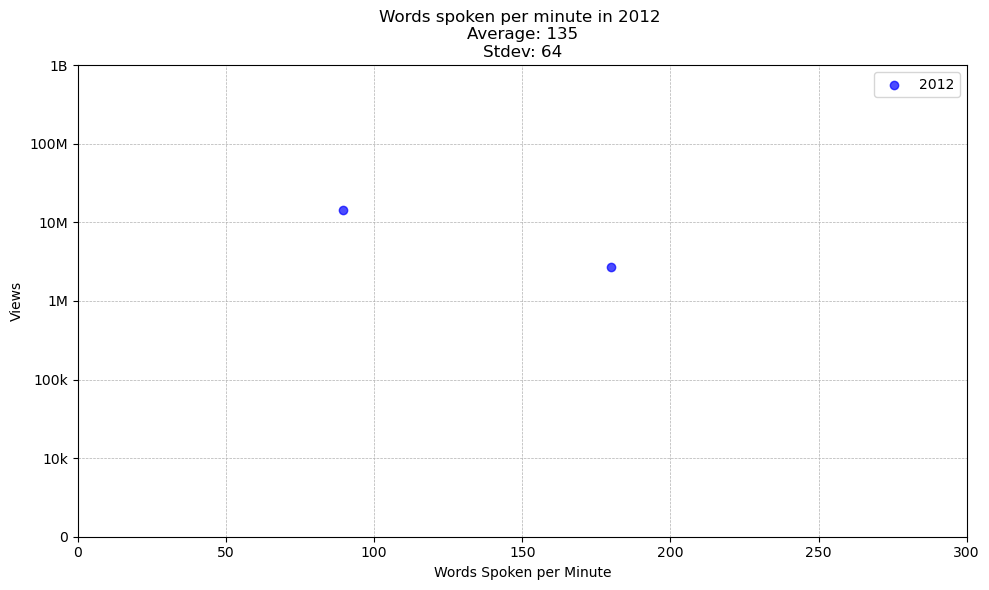

<Figure size 640x480 with 0 Axes>

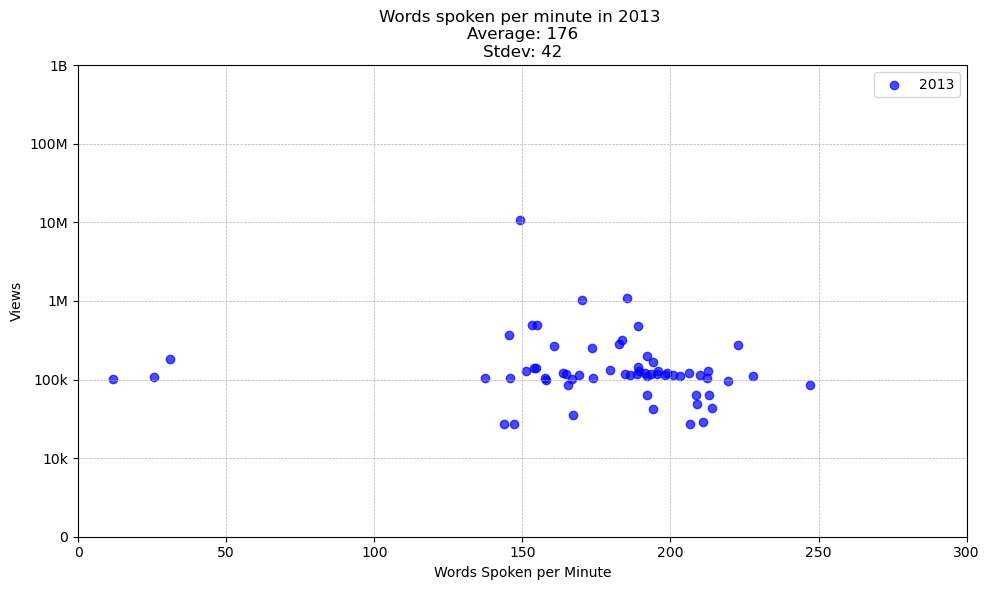

<Figure size 640x480 with 0 Axes>

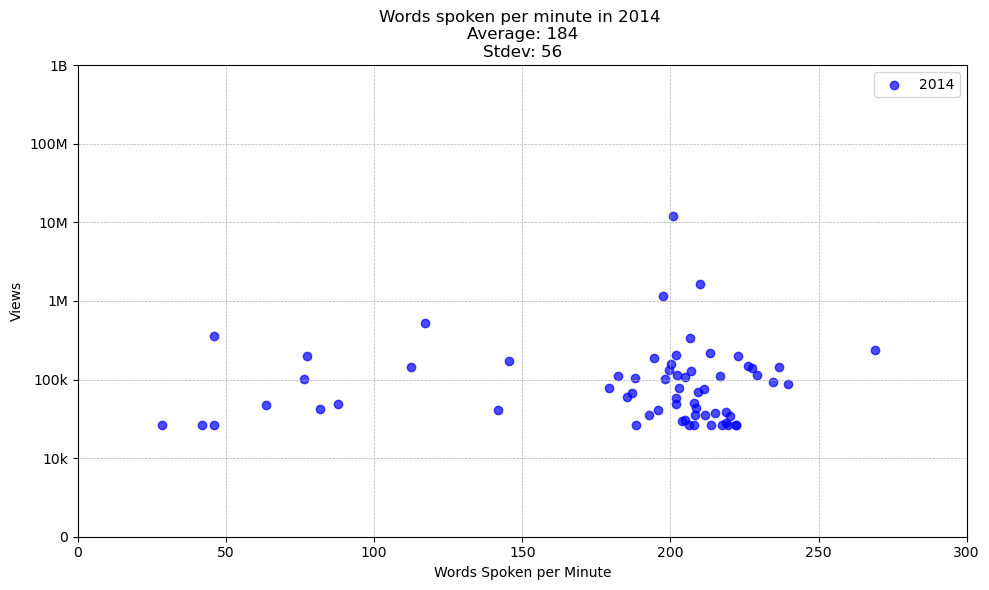

<Figure size 640x480 with 0 Axes>

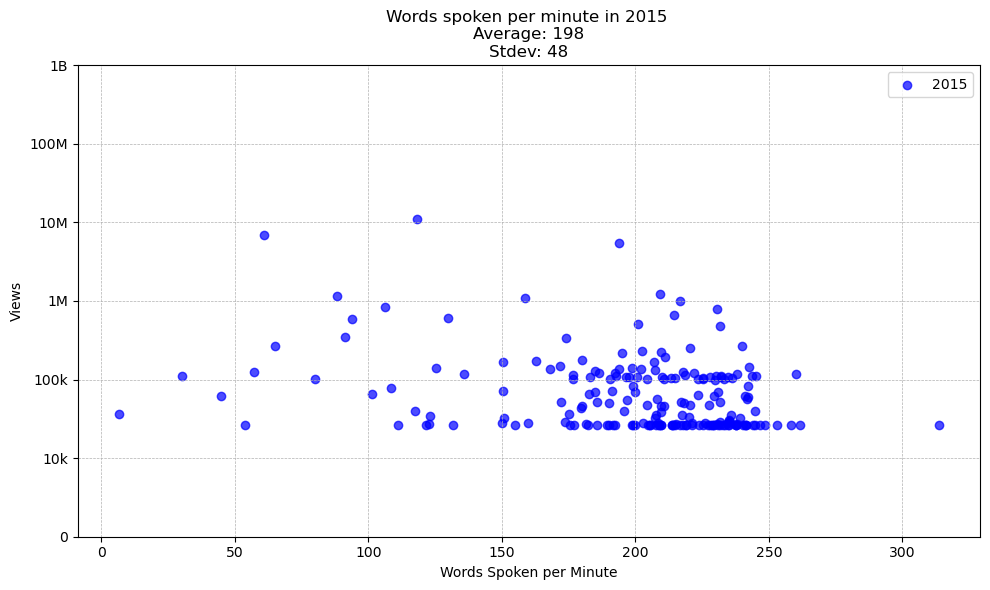

<Figure size 640x480 with 0 Axes>

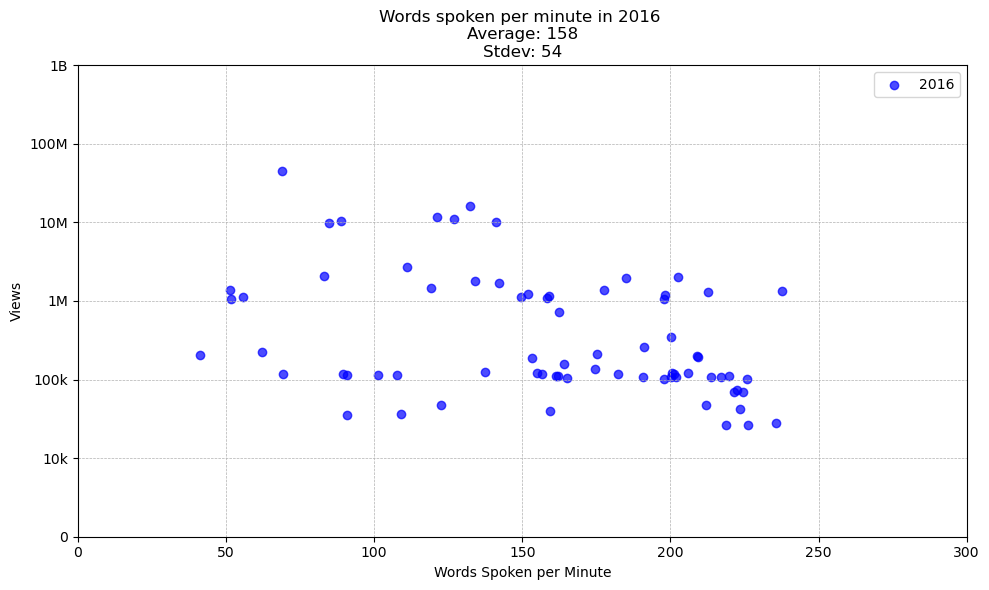

<Figure size 640x480 with 0 Axes>

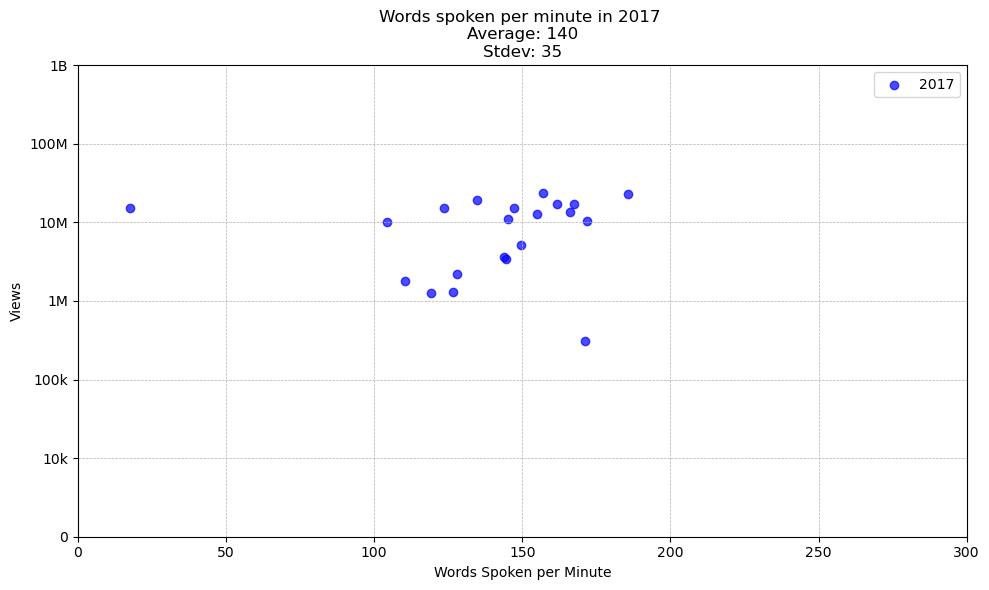

<Figure size 640x480 with 0 Axes>

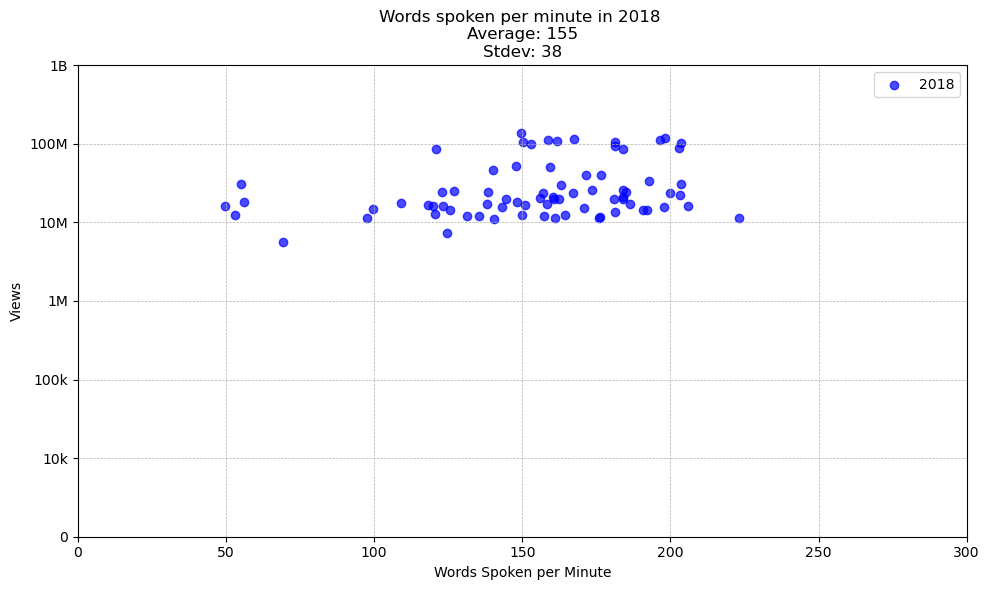

<Figure size 640x480 with 0 Axes>

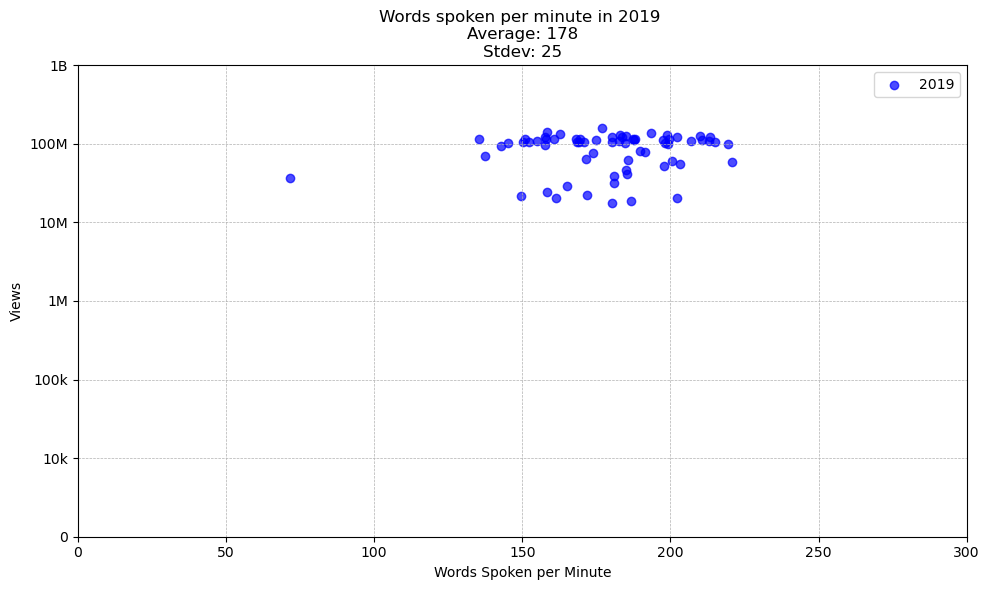

<Figure size 640x480 with 0 Axes>

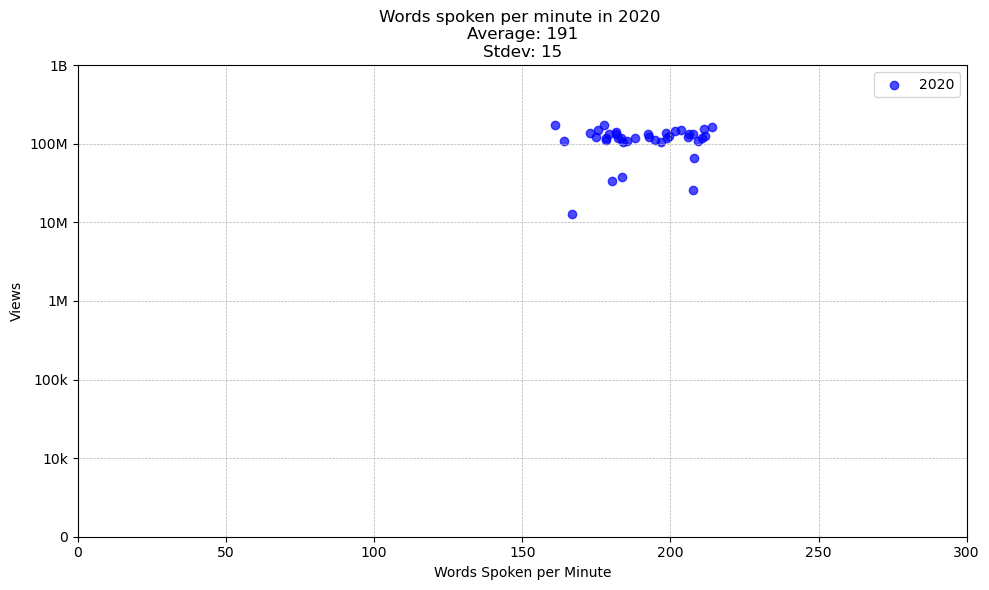

<Figure size 640x480 with 0 Axes>

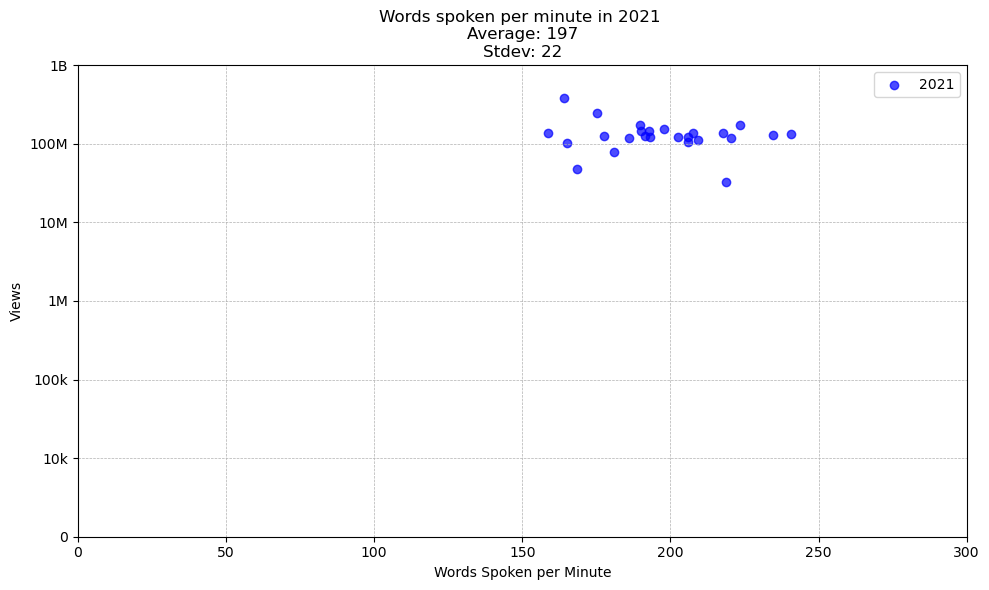

<Figure size 640x480 with 0 Axes>

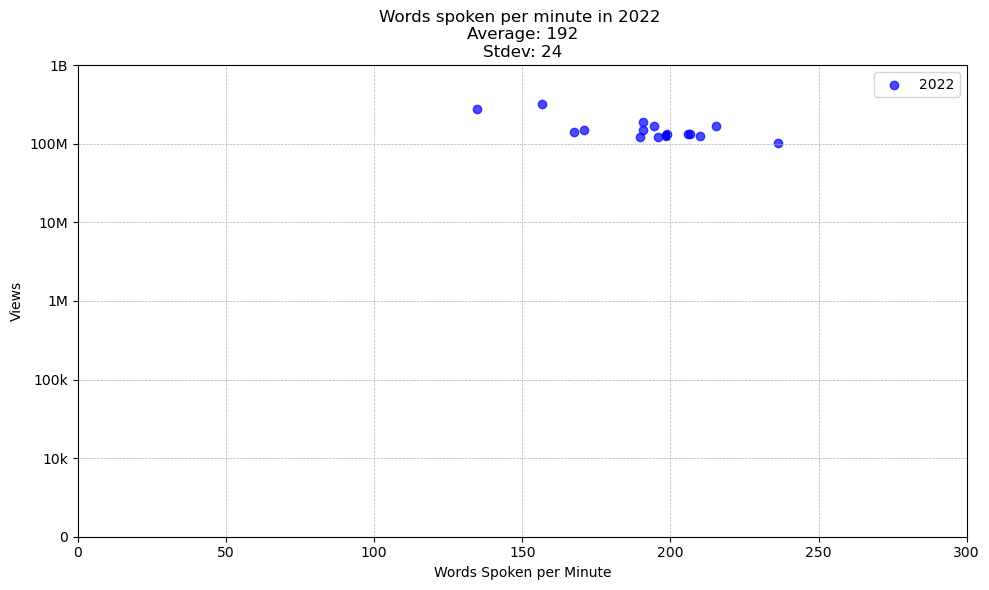

<Figure size 640x480 with 0 Axes>

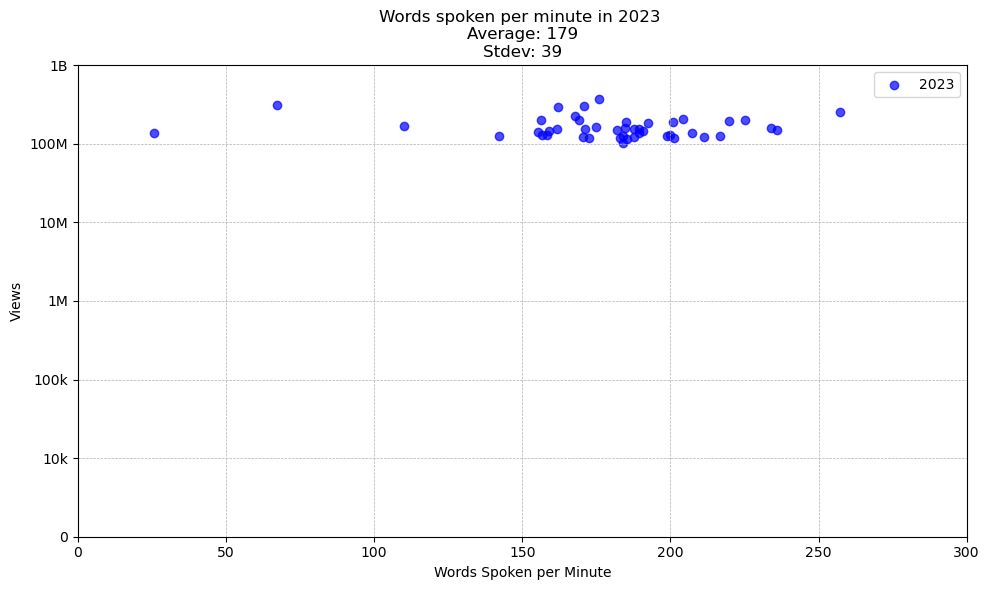

<Figure size 640x480 with 0 Axes>

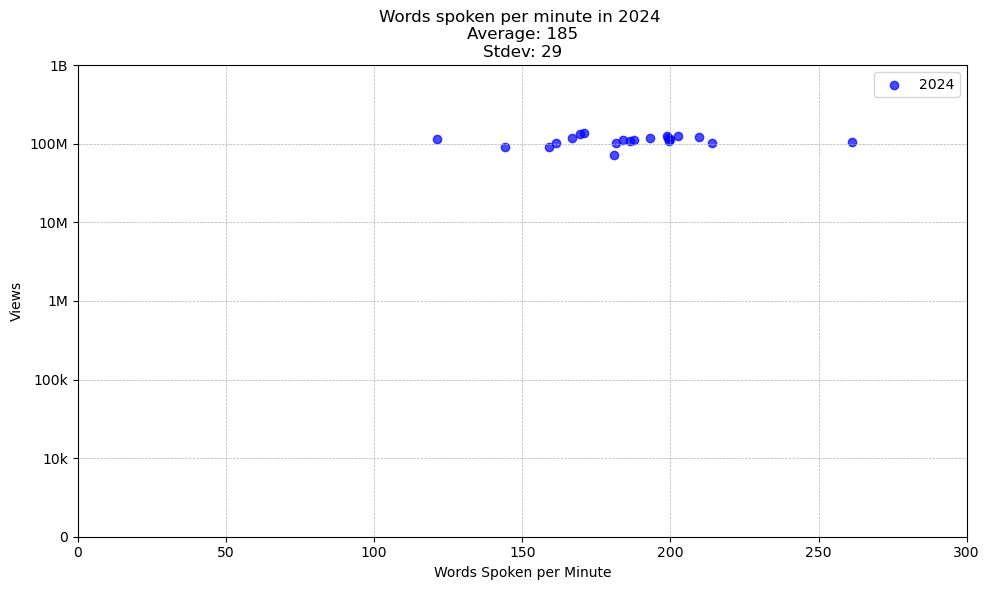

<Figure size 640x480 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt
from statistics import mean, stdev

y_tick_labels = ['0', '10k', '100k', '1M', '10M', '100M', '1B']
y_tick_positions = [0, 1, 2, 3, 4, 5, 6]  # Equal spacing for each label
y_actual_values = [0, 10**4, 10**5, 10**6, 10**7, 10**8, 10**9]
x_tick_positions = [0, 50, 100, 150, 200, 250, 300]

years = sorted(years)

for year in years:
    video_rates = rates_per_year[year]
    video_ids = [videoId for videoId, ref in p.first_word_in_video.items() if int(ref.publishedAt.split('-')[0]) == year]
    # Check if there are videos for this year (avoid empty plots)
    if len(video_rates) > 0 and len(video_ids) > 0:
        video_views = []
        for video_id in video_ids:
            video_views.append(int(p.video_stats[video_id]['viewCount']))  # Ensure view counts are integers
        # Convert actual view counts to positions
        video_views_positions = []
        for view in video_views:
            for i in range(len(y_actual_values) - 1):
                if y_actual_values[i] <= view < y_actual_values[i + 1]:
                    position = y_tick_positions[i] + (y_tick_positions[i + 1] - y_tick_positions[i]) * ((view - y_actual_values[i]) / (y_actual_values[i + 1] - y_actual_values[i]))
                    video_views_positions.append(position)
                    break
            else:
                video_views_positions.append(y_tick_positions[-1])

        rate_stdev = stdev(video_rates)
        rate_mean = mean(video_rates)

        plt.figure(figsize=(10, 6))
        plt.scatter(video_rates, video_views_positions, color='blue', alpha=0.7, label=f'{year}')
        plt.xlabel('Words Spoken per Minute')
        plt.ylabel('Views')
        plt.title(f'Words spoken per minute in {year} \n'
                  f'Average: {rate_mean:.0f}\n'
                  f'Stdev: {rate_stdev:.0f}')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()
        plt.yticks(y_tick_positions, y_tick_labels)
        plt.xticks(x_tick_positions)
        plt.tight_layout()
        plt.show()
        plt.clf()

### Plot for each years combined

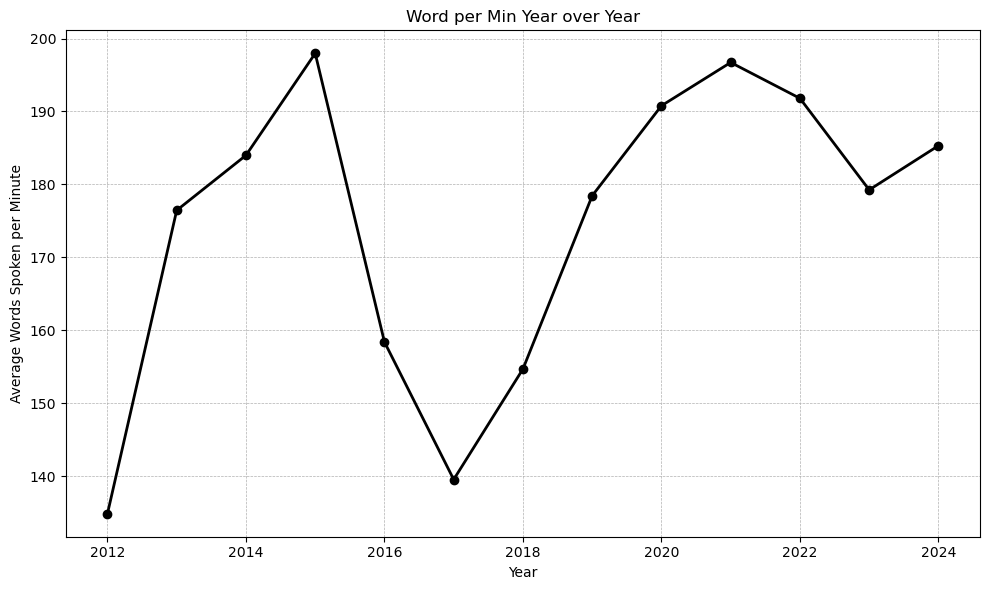

In [5]:
import matplotlib.pyplot as plt

# Calculate the average words spoken per minute for each year
average_words_per_minute = {}
for year, rates in rates_per_year.items():
    average_words_per_minute[year] = sum(rates) / len(rates)

# Sort years for plotting
sorted_years = sorted(average_words_per_minute.keys())
average_rates = [average_words_per_minute[year] for year in sorted_years]

plt.figure(figsize=(10, 6))
plt.plot(sorted_years, average_rates, color='black', linewidth=2, marker='o')
plt.xlabel('Year')
plt.ylabel('Average Words Spoken per Minute')
plt.title('Word per Min Year over Year')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Sentiment Analysis

Here, we perform sentiment analysis on the captions data and generate a scatter plot of the results.


In [6]:
def getSentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    return scores

p = Parser()
p.parse('mrbeast', cut_off_date='2012-01-01')

sentiment_by_year = defaultdict(lambda: defaultdict(list))
text_by_year = defaultdict(list)

most_negative_video = {"videoId": None, "title": None, "publishedAt": None, "negative": -1.0}
most_positive_video = {"videoId": None, "title": None, "publishedAt": None, "positive": -1.0}

print("videoId, words-per-min, viewCount, publishedAt, negative, neutral, positive, compound")
for videoId, first_ref in p.first_word_in_video.items():
    ref = first_ref
    year = int(ref.publishedAt.split('-')[0])
    word_counter = 0
    end = 0
    text = []
    while ref:
        word_counter += 1
        end = ref.start + ref.duration
        text_by_year[year].append(ref.word)
        text.append(ref.word)

        ref = ref.next_ref

    rate = word_counter / (end / 60.0)
    stats = p.video_stats[videoId]
    sentiment = getSentiment(' '.join(text))
    print('%s %.2f %s %s %g %g %g %g' % (videoId, rate, stats['viewCount'], first_ref.publishedAt, sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']))
    sentiment_by_year[year]['neg'].append(sentiment['neg'])
    sentiment_by_year[year]['neu'].append(sentiment['neu'])
    sentiment_by_year[year]['pos'].append(sentiment['pos'])
    sentiment_by_year[year]['compound'].append(sentiment['compound'])
    
    if sentiment['neg'] > most_negative_video["negative"]:
        most_negative_video = {
            "videoId": videoId,
            "title": first_ref.title,
            "publishedAt": first_ref.publishedAt,
            "negative": sentiment['neg']
        }
    if sentiment['pos'] > most_positive_video["positive"]:
        most_positive_video = {
            "videoId": videoId,
            "title": first_ref.title,
            "publishedAt": first_ref.publishedAt,
            "positive": sentiment['pos']
        }

print()
print("Year over Year sentiment:")
print("year, negative, neutral, positive, compound")
for year, text in sorted(text_by_year.items()):
    sentiment = getSentiment(' '.join(text))
    print('%s %g %g %g %g' % (year, sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']))
    
print()
print("Most Negative Video")
print("videoId: %s, title: %s, publishedAt: %s, negative sentiment: %g" % (most_negative_video["videoId"], most_negative_video["title"], most_negative_video["publishedAt"], most_negative_video["negative"]))

print()
print("Most Positive Video")
print("videoId: %s, title: %s, publishedAt: %s, positive sentiment: %g" % (most_positive_video["videoId"], most_positive_video["title"], most_positive_video["publishedAt"], most_positive_video["positive"]))

videoId, words-per-min, viewCount, publishedAt, negative, neutral, positive, compound
-0zoWMSEOGg 135.40 17678696 2018-07-25T21:11:00Z 0.135 0.714 0.152 0.9949
-2IFrMOM36w 186.30 157309 2013-03-31T20:49:28Z 0.119 0.696 0.185 0.996
-cWVrFABWHw 107.76 147133 2016-01-26T21:38:09Z 0.067 0.83 0.104 0.9001
-hrPQFaDVKQ 198.19 147365 2013-08-16T20:34:58Z 0.071 0.738 0.19 0.9975
-o_8CDbFMJ0 230.61 48525 2015-07-03T19:26:09Z 0.122 0.767 0.112 -0.8872
-rdYtmUejSE 112.52 245022 2014-04-05T13:00:05Z 0.201 0.662 0.137 -0.9954
-V3-fhJQZkk 242.18 92959 2015-08-01T10:00:01Z 0.036 0.749 0.215 0.9996
-z349CGAOXs 191.26 169916 2013-04-21T16:37:08Z 0.012 0.775 0.212 0.9958
00NgUctWoLQ 165.07 103718372 2021-12-18T21:00:00Z 0.082 0.747 0.171 0.9997
0CTp1a-aCUM 170.66 258674453 2022-12-03T21:00:00Z 0.08 0.776 0.145 0.9996
0DaMUhgcAqo 184.52 111155037 2019-08-10T20:00:00Z 0.046 0.763 0.19 0.9999
0dg2eR2NSQ0 145.53 315177 2014-11-23T17:37:28Z 0.08 0.784 0.136 0.9508
0e3GPea1Tyg 163.99 620530252 2021-11-24T21:00

### Plot the *positive* and *negative* words

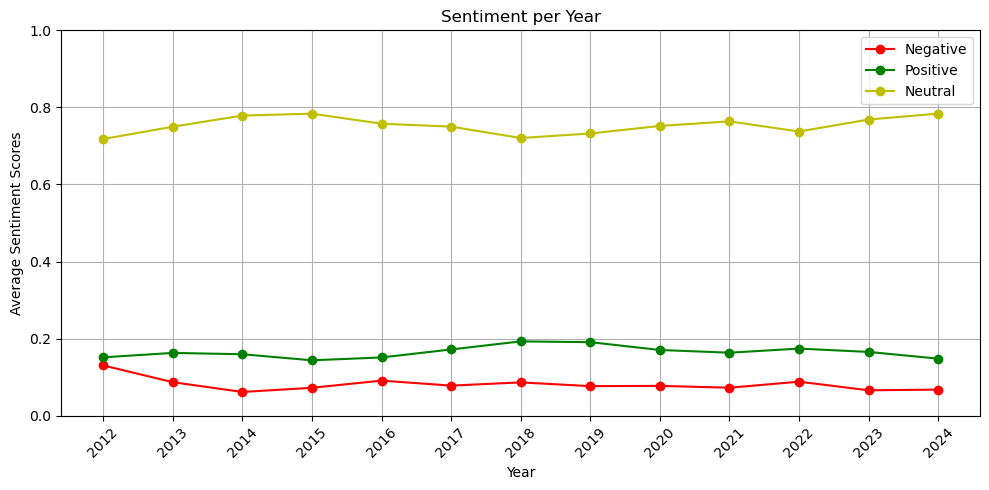

In [7]:
average_sentiment_by_year = {}
for year, sentiments in sentiment_by_year.items():
    average_sentiment_by_year[year] = {k: sum(v) / len(v) for k, v in sentiments.items()}

years = sorted(average_sentiment_by_year.keys())
avg_neg = [average_sentiment_by_year[year]['neg'] for year in years]
avg_pos = [average_sentiment_by_year[year]['pos'] for year in years]
avg_neu = [average_sentiment_by_year[year]['neu'] for year in years]

plt.figure(figsize=(10, 5))
plt.plot(years, avg_neg, marker='o', linestyle='-', color='r', label='Negative')
plt.plot(years, avg_pos, marker='o', linestyle='-', color='g', label='Positive')
plt.plot(years, avg_neu, marker='o', linestyle='-', color='y', label='Neutral')
plt.title('Sentiment per Year')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Scores')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()

## Search Functionality

In this section, we implemented search functionalities to find specific words, phrases, or patterns in the captions data.


In [8]:
p = Parser()
p.parse('mrbeast')

print('"lets go":')
lets_go_count = 0
for ref in p.findWords(['lets', 'go']):
    # print(ref.link, ref.text)
    lets_go_count += 1
print(f'Total "lets go" count: {lets_go_count}')
print()

print ('"feast.*":')
feast_count = 0
for words in p.reWord('feast.*'):
    # print(words)
    feast_count += 1
print(f'Total "feast.*" count: {feast_count}')
print()

print('"feastables":')
feastables_count = 0
for ref in p.findWord('feastables'):
    # print(ref.link, ref.text)
    feastables_count += 1
print(f'Total "feastables" count: {feastables_count}')
print()

print('"sponsor":')
sponsor_count = 0
for ref in p.findWord('sponsor'):
    # print(ref.link, ref.text)
    sponsor_count += 1
print(f'Total "sponsor" count: {sponsor_count}')
print()


"lets go":
Total "lets go" count: 819

"feast.*":
Total "feast.*" count: 268

"feastables":
Total "feastables" count: 57

"sponsor":
Total "sponsor" count: 51

